<a href="https://colab.research.google.com/github/EmmanueleVilla/Tensorflow---Serie-youtube/blob/main/Tensorflow%20%235%20-%20Rete%20Convoluzionale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.emmanuelevilla.com/datasets/food-6.zip

--2022-08-22 15:08:40--  https://www.emmanuelevilla.com/datasets/food-6.zip
Resolving www.emmanuelevilla.com (www.emmanuelevilla.com)... 188.68.50.253
Connecting to www.emmanuelevilla.com (www.emmanuelevilla.com)|188.68.50.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293676082 (280M) [application/zip]
Saving to: ‘food-6.zip’

food-6.zip          100%[===================>] 280.07M  8.55MB/s    in 34s     

2022-08-22 15:09:15 (8.24 MB/s) - ‘food-6.zip’ saved [293676082/293676082]



In [2]:
!unzip -q food-6.zip -d food-6

In [3]:
!rm food-6.zip

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf
import os, random

Populating the interactive namespace from numpy and matplotlib


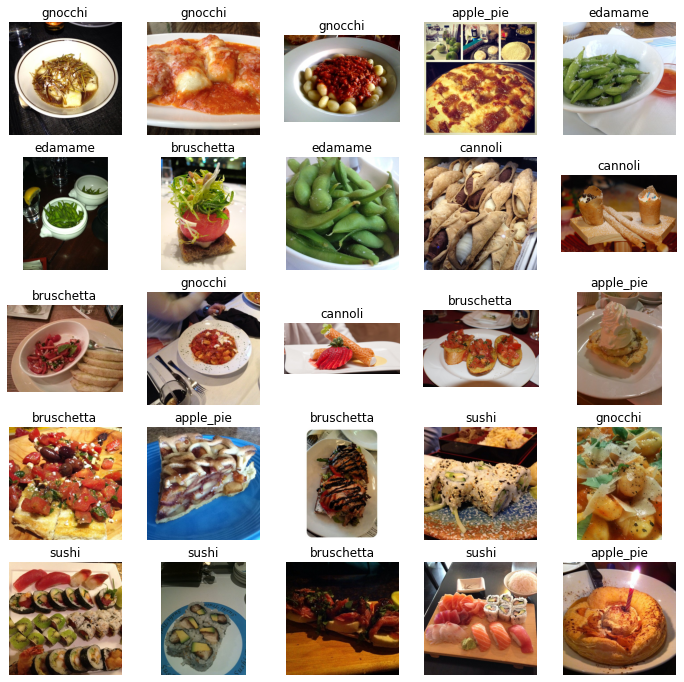

In [5]:
plt.figure(figsize=(12,12))
root = "food-6"
for i in range(25):
  random_folder = random.choice(os.listdir(root))
  filename = random.choice(os.listdir(f"{root}/{random_folder}"))
  path = f"{root}/{random_folder}/{filename}"
  img = mpimg.imread(path)
  plt.subplot(5, 5, i + 1)
  plt.imshow(img)
  plt.axis("off")
  plt.title(random_folder)
plt.show()

In [6]:
full_data = tf.keras.utils.image_dataset_from_directory(
    root,
    image_size=(256,256),
    crop_to_aspect_ratio=True,
    seed=42
)
full_data, len(full_data)

Found 6000 files belonging to 6 classes.


(<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 188)

In [7]:
train_size = int(0.7 * len(full_data))
val_size = int(0.15 * len(full_data))
test_size = int(0.15 * len(full_data))

train_data = full_data.take(train_size)
test_data = full_data.skip(train_size)
val_data = test_data.skip(test_size)
test_data = test_data.take(test_size)

len(train_data), len(test_data), len(val_data)

(131, 28, 29)

In [8]:
print(full_data.class_names)

['apple_pie', 'bruschetta', 'cannoli', 'edamame', 'gnocchi', 'sushi']


In [9]:
train_data_prefetched = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_prefetched = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_prefetched = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
train_data_prefetched

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

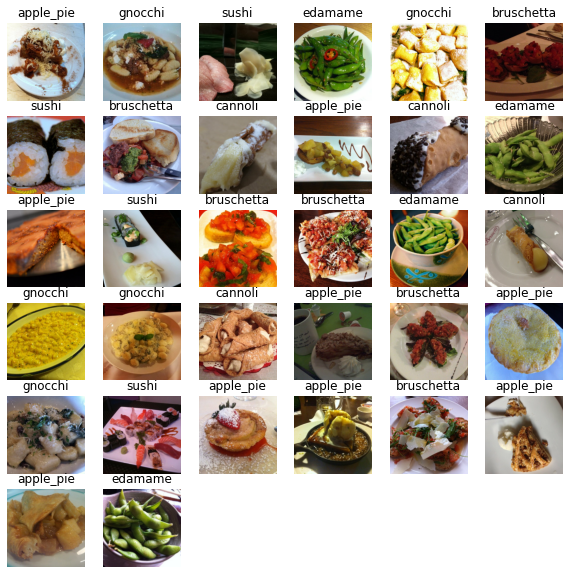

In [10]:
plt.figure(figsize=(10,10))
class_names = full_data.class_names
for images, labels in train_data.take(1):
  for i in range(32):
    ax = plt.subplot(6, 6, i +1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(16, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(full_data.class_names), activation="softmax")
])

In [31]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [32]:
training = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Epoch 1/5
131/131 [==============================] - 23s 168ms/step - loss: 1.6452 - accuracy: 0.3328 - val_loss: 1.4539 - val_accuracy: 0.4200
Epoch 2/5
131/131 [==============================] - 22s 162ms/step - loss: 1.3287 - accuracy: 0.4678 - val_loss: 1.2862 - val_accuracy: 0.4814
Epoch 3/5
131/131 [==============================] - 21s 160ms/step - loss: 1.1686 - accuracy: 0.5537 - val_loss: 1.3694 - val_accuracy: 0.4693
Epoch 4/5
131/131 [==============================] - 21s 161ms/step - loss: 0.9542 - accuracy: 0.6493 - val_loss: 1.4402 - val_accuracy: 0.4463
Epoch 5/5
131/131 [==============================] - 22s 169ms/step - loss: 0.6579 - accuracy: 0.7698 - val_loss: 1.6139 - val_accuracy: 0.4770


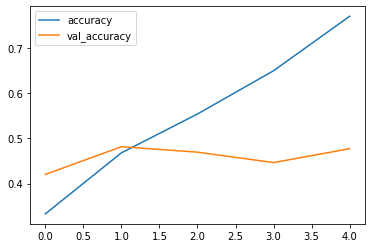

In [33]:
pd.DataFrame(training.history)[["accuracy", "val_accuracy"]].plot()